This file will be used to train the policies and use them to generate the trajectories. 

Let's start by creating the environment we will be using: Cartpool

In [1]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)

C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is mar

[0]

For the definition of classes and functions for training the policies, refer to train_policy_func.py file 

In [4]:
# to test

from Train_policy_func import Policy, device
from Generate_traj_func import generate_trajectory

policy = Policy(state_size=4, action_size=2).to(device)
# optionally: policy.load_state_dict(torch.load("best_policy.pth"))

# Generate one trajectory: 
traj = generate_trajectory(policy, env)
print(f"Episode length: {len(traj)}, Total reward: {sum(s['reward'] for s in traj)}")



Episode length: 17, Total reward: 17.0


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [5]:
# Training loop

from PPO import ppo_update, RolloutBuffer


# Hyperparameters
env_name     = "CartPole-v0"
total_steps  = 1000     # per update
updates      = 100        # how many times to run rollout+update
clip_eps     = 0.2
gamma, lam   = 0.99, 0.95
lr           = 3e-4
batch_size   = 64
epochs       = 4

# Instantiate
env       = gym.make(env_name)
policy    = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)
buffer    = RolloutBuffer()
avg_returns = []

for update in range(updates):
    state = env.reset()
    steps = 0

    # for tracking episode returns within this batch
    episode_rewards     = []
    current_ep_reward   = 0.0

    # 1) Roll out until we have total_steps
    while steps < total_steps:
        action, logp, value = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        buffer.store(state, action, logp, reward, value, done)
        state = next_state
        steps += 1

        # accumulate for this episode
        current_ep_reward += reward

        if done:
            episode_rewards.append(current_ep_reward)
            current_ep_reward = 0.0
            state = env.reset()

    # in case the last episode didn’t terminate exactly on total_steps
    if current_ep_reward > 0.0:
        episode_rewards.append(current_ep_reward)

    # compute average return for this batch
    avg_ret = np.mean(episode_rewards)
    avg_returns.append(avg_ret)

    # 2) Compute last value (for GAE)
    _, last_value = policy(torch.from_numpy(state).float().unsqueeze(0).to(device))

    # 3) PPO update
    ppo_update(policy, optimizer, buffer, clip_eps, epochs, batch_size)

    # 4) Saving checkpoint of the policy to get pi2
    if (update + 1) % 50 == 0:
        print(f"Update {update+1}/{updates} completed.")
        torch.save(policy.state_dict(), f"pi2_checkpoint_{update}.pth")

# 5) at the end, save pi1
torch.save(policy.state_dict(), "pi1_final.pth")
print("Saved final policy as pi1_final.pth")



C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\turin\OneDrive\EPFL\Master\MA2\RL\RLHF\Git RLHF\RL-RLHF\PPO.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v  = torch.tensor(v).float().to(device)


Update 50/100 completed.
Update 100/100 completed.
Saved final policy as pi1_final.pth


In [6]:
## Generate preference pairs

# Load π₂ (weak) and π₁ (strong)
from pairs_generator import sample_preference_pairs

pi2 = Policy().to(device)
pi2.load_state_dict(torch.load("pi2_checkpoint_49.pth"))
pi2.eval()

pi1 = Policy().to(device)
pi1.load_state_dict(torch.load("pi1_final.pth"))
pi1.eval()

# Generate one trajectory each to inspect
traj2 = generate_trajectory(pi2, env)
traj1 = generate_trajectory(pi1, env)

print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")
print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")

prefs = sample_preference_pairs(pi1, pi2, env, K=200) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")


C:\Users\turin\AppData\Local\Temp\ipykernel_101660\4012433335.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi2.load_state_dict(torch.load("pi2_checkpoint_49.pth"))
C:

π₂ → length 22, total reward 22.0
π₁ → length 23, total reward 23.0
Collected 200 preference pairs.


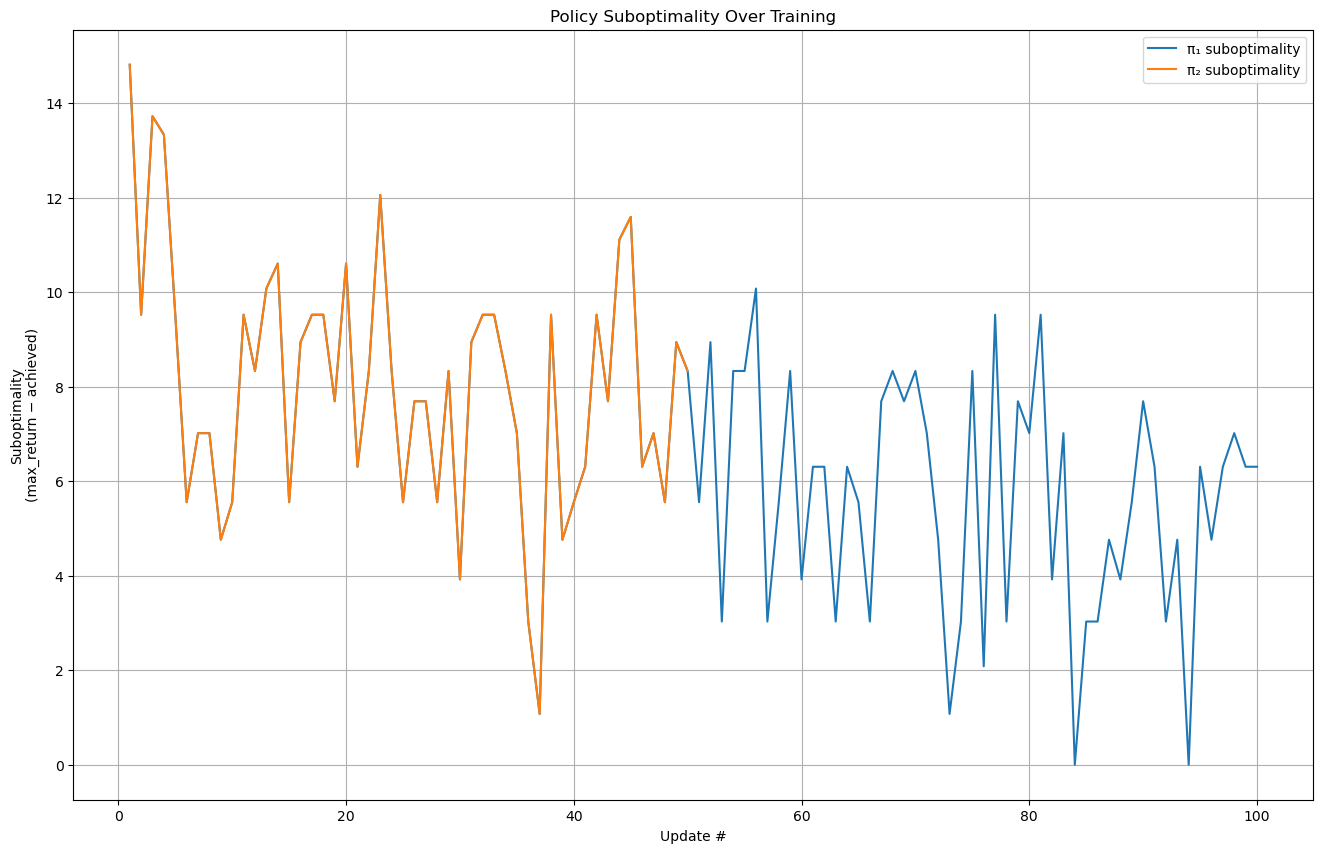

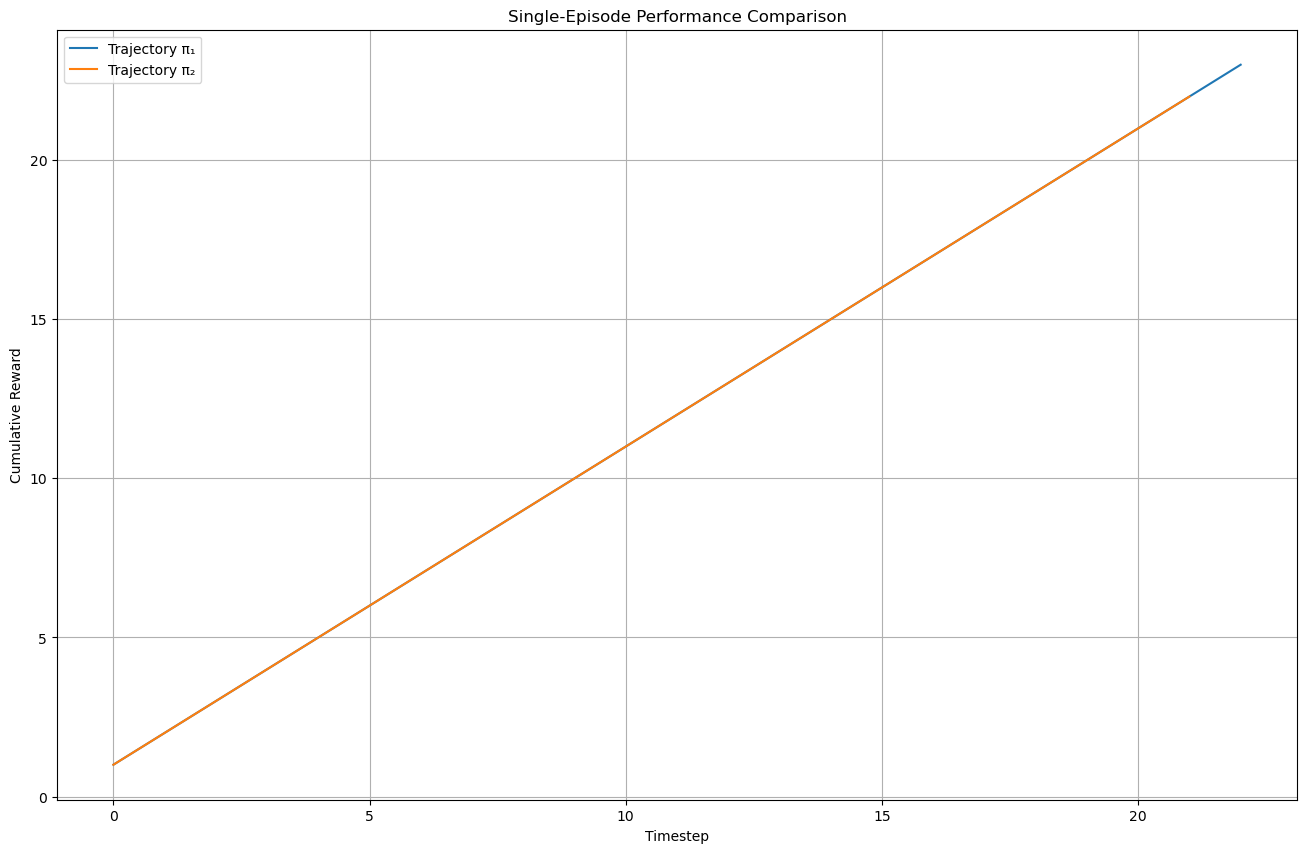

In [7]:
## Visulization of the policies and trajectories
# %autoreload 2
from Generate_traj_func import plot_suboptimality, plot_trajectory_performance


plot_suboptimality(avg_returns, avg_returns[0:int(len(avg_returns)/2)])
plot_trajectory_performance(traj1, traj2) 